In [1]:
!unzip "/content/archive (1).zip" -d "news"

Streaming output truncated to the last 5000 lines.
  inflating: news/BBC News Summary/Summaries/sport/363.txt  
  inflating: news/BBC News Summary/Summaries/sport/364.txt  
  inflating: news/BBC News Summary/Summaries/sport/365.txt  
  inflating: news/BBC News Summary/Summaries/sport/366.txt  
  inflating: news/BBC News Summary/Summaries/sport/367.txt  
  inflating: news/BBC News Summary/Summaries/sport/368.txt  
  inflating: news/BBC News Summary/Summaries/sport/369.txt  
  inflating: news/BBC News Summary/Summaries/sport/370.txt  
  inflating: news/BBC News Summary/Summaries/sport/371.txt  
  inflating: news/BBC News Summary/Summaries/sport/372.txt  
  inflating: news/BBC News Summary/Summaries/sport/373.txt  
  inflating: news/BBC News Summary/Summaries/sport/374.txt  
  inflating: news/BBC News Summary/Summaries/sport/375.txt  
  inflating: news/BBC News Summary/Summaries/sport/376.txt  
  inflating: news/BBC News Summary/Summaries/sport/377.txt  
  inflating: news/BBC News Summary

In [2]:
from pathlib import Path
news_path=Path("news/bbc news summary/BBC News Summary/News Articles/")
Summary_path=Path("news/bbc news summary/BBC News Summary/Summaries/")

In [3]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

In [4]:
from nltk.corpus import stopwords   

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
stop_words = set(stopwords.words('english')) 
def clean_text(text):
    String = text.lower()
    String = BeautifulSoup(String, "lxml").text
    String = re.sub(r'\([^)]*\)', '', String)
    String = re.sub('"','', String)
    String = ' '.join([contraction_mapping[s] if s in contraction_mapping else s for s in String.split(" ")])    
    String = re.sub(r"'s\b","",String)
    String = re.sub("[^a-zA-Z]", " ", String) 
    tokens = [k for k in String.split() if not k in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [8]:

def clean_summary(text):
    String = re.sub('"','', text)
    String = ' '.join([contraction_mapping[s] if s in contraction_mapping else s for s in String.split(" ")])    
    String = re.sub(r"'s\b","",String)
    # Used to replace any other expressions except A-Z to " ".
    String = re.sub("[^a-zA-Z]", " ", String)

    # To change upper letters to lower letters.
    String = String.lower()

    tokens=String.split()
    #String=''
    #for i in tokens:
     #   if len(i)>1:                                 
      #      String=String+i+' '  
    return String

In [9]:
def extract(filepath):
    pattern = r'(\w+)/(\d+)\.txt$'
    category, file_id = re.search(pattern, str(filepath)).groups()
    with open(filepath, 'r', encoding='unicode_escape') as f:
        text = f.read()
        return category, file_id, text

In [10]:
articles_data = list(map(extract, news_path.glob('*/*.txt')))
summaries_data = list(map(extract, Summary_path.glob('*/*.txt')))

articles_df = pd.DataFrame(articles_data, columns=('Category', 'ID', 'Article'))
summaries_df = pd.DataFrame(summaries_data, columns=('Category', 'ID', 'Summary'))

df = articles_df.merge(summaries_df, how='inner', on=('Category', 'ID'))

In [11]:
df.head()

,Category,ID,Article,Summary
0,sport,350,Dal Maso in to replace Bergamasco\n\nDavid dal...,R de Marigny (Parma); Mirco Bergamasco (Stade ...
1,sport,209,Gallas sees two-horse race\n\nChelsea's Willia...,You need a bit of both but it will be as hard ...
2,sport,148,Palace threat over Cantona masks\n\nManchester...,Manchester United fans wearing Eric Cantona ma...
3,sport,246,Chelsea hold Arsenal\n\nA gripping game betwee...,Thierry Henry produced a sublime strike to put...
4,sport,387,Lions blow to World Cup winners\n\nBritish and...,"But Woodward added: ""The key thing that I want..."


In [16]:
df1=df.copy() # Copy of the dataframe which we will use to make the changes.
cleaned_text = []
for i in df1['Article']:
    cleaned_text.append(clean_text(i))
cleaned_summary = []
for i in df1['Summary']:
    cleaned_summary.append(clean_summary(i))

df1['Article']=cleaned_text
df1['Summary']=cleaned_summary
df1['Article'].replace('', np.nan, inplace=True)
df1.dropna(axis=0,inplace=True)

In [17]:
df1['Summary'] = df1['Summary'].apply(lambda x : '<START> '+ x + ' <END>')

In [18]:
for i in range(5):
    print("Review:",df1['Article'][i])
    print("Summary:",df1['Summary'][i])
    print("\n")

Review: dal maso replace bergamasco david dal maso handed task replacing injured mauro bergamasco flanker italy team face scotland saturday alessandro troncon continues scrum half despite return fitness paul griffen experienced cristian stoica recalled centre expense walter pozzebon going scotland first away win nothing else said manager marco bollesan really believe team faith saturday game lost player like mauro bergamasco important john put together best team present ever marigny mirco bergamasco stoica masi nitoglia orquera troncon cicero ongaro castrogiovanni dellape bortolami persico dal maso parisse intoppa perugini del fava orlando griffen pedrazzi robertson
Summary: <START> r de marigny  parma   mirco bergamasco  stade francais   c stoica  montpellier   a masi  viadana   l nitoglia  calvisano   l orquera  padova   a troncon  treviso   a lo cicero  l aquilla   f ongaro  treviso   m castrogiovanni  calvisano   s dellape  agen   m bortolami  narbonne  capt   a persico  agen   d d

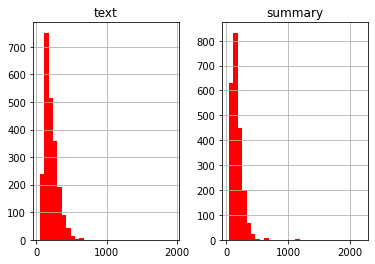

In [19]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df1['Article']:
      text_word_count.append(len(i.split()))
      

for i in df1['Summary']:
      summary_word_count.append(len(i.split()))
length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30,color='r')
plt.show()

In [20]:
# It gives the ouput within the range of max_len_Summary
max_len_text=500
max_len_summary=300

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation data

x_tr,x_val,y_tr,y_val=train_test_split(df1['Article'],df1['Summary'],test_size=0.05,random_state=0,shuffle=True) 

In [22]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr   =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [23]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [24]:
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention

In [25]:
from keras import backend as K 
K.clear_session() 
latent_dim = 1000
embedding_dim=400
# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb =  Embedding(x_voc_size, embedding_dim,trainable=True)(encoder_inputs)

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, embedding_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

attention =Attention()
attn_out = attention([decoder_outputs,encoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 200)     5376400     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 500, 800),   3203200     ['embedding[0][0]']              
                                 (None, 800),                                                     
                                 (None, 800)]                                                     
                                                                                              

In [26]:
#Used to compile the model using adam as optimizer

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [27]:
#It will stop the training of the model whenever validation los is not changing for 4 epochs.

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=4)

In [28]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/30
34/34 [==============================] - 81s 2s/step - loss: 5.3391 - val_loss: 4.1766
Epoch 2/30
34/34 [==============================] - 73s 2s/step - loss: 4.1802 - val_loss: 3.7733
Epoch 3/30
34/34 [==============================] - 75s 2s/step - loss: 3.9880 - val_loss: 3.7336
Epoch 4/30
34/34 [==============================] - 76s 2s/step - loss: 3.9289 - val_loss: 3.7064
Epoch 5/30
34/34 [==============================] - 76s 2s/step - loss: 3.8784 - val_loss: 3.6568
Epoch 6/30
34/34 [==============================] - 76s 2s/step - loss: 3.8075 - val_loss: 3.6071
Epoch 7/30
34/34 [==============================] - 76s 2s/step - loss: 3.7549 - val_loss: 3.5780
Epoch 8/30
34/34 [==============================] - 76s 2s/step - loss: 3.6940 - val_loss: 3.5558
Epoch 9/30
34/34 [==============================] - 76s 2s/step - loss: 3.6414 - val_loss: 3.5358
Epoch 10/30
34/34 [==============================] - 76s 2s/step - loss: 3.6065 - val_loss: 3.5100
Epoch 11/30
34/34 [

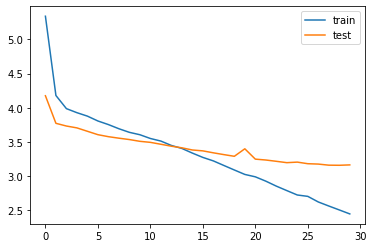

In [30]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [31]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [32]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf = attention([decoder_outputs2,decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [33]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [34]:
def seq2summary(input_seq):
    String=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        String=String+reverse_target_word_index[i]+' '
    return String

def seq2text(input_seq):
    String=''
    for i in input_seq:
      if(i!=0):
        String=String+reverse_source_word_index[i]+' '
    return String

In [38]:
for i in range(1,5):
  print("Review:",seq2text(x_tr[i]))
  print("Original summary:",seq2summary(y_tr[i]))
  print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
  print("\n")

Review: producers called podcasting strongest proponent former mtv host adam curry podcasting takes name apple ipod although need ipod create one listen podcast podcast basically internet based radio show podcasters create usually comfort home need microphone editing software upload shows internet others download listen free using technology based xml computer code rss really simple syndication listeners subscribe podcasts collected automatically bit software curry pioneered latest files shows picked music playing device automatically curry records hosts edits produce daily minute podcast called daily source code wants make podcasting next big thing says extension childhood love radio gadgetry always technologies wires explains parents gave radio shack project kit allows build transmitter subsequently transmitter mom drive around block see far would reach car radio curry american grew netherlands hosted illegal pirate radio shows dutch capital tried university ended back holland hosted

In [ ]:
from rouge import Rouge 
r=Rouge()
original_summary=seq2summary(y_tr[0])
predicted_summary=decode_sequence(x_tr[0].reshape(1,max_len_text))
r.get_scores(predicted_summary, original_summary))

[{'rouge-1': {'r': 0.2647058823529412, 'p': 0.45, 'f': 0.3333333286694102}, 'rouge-2': {'r': 0.043010752688172046, 'p': 0.058823529411764705, 'f': 0.049689436114347924}, 'rouge-l': {'r': 0.19117647058823528, 'p': 0.325, 'f': 0.24074073607681765}}]


In [42]:
pip install rouge
from rouge import Rouge 
r=Rouge()
original_summary=seq2summary(y_val[0])
predicted_summary=decode_sequence(x_val[0].reshape(1,max_len_text))
r.get_scores(predicted_summary, original_summary)

[{'rouge-1': {'f': 0.1589403940879787, 'p': 0.3870967741935484, 'r': 0.1},
  'rouge-2': {'f': 0.015564198755470245,
   'p': 0.03333333333333333,
   'r': 0.01015228426395939},
  'rouge-l': {'f': 0.14569536097539587,
   'p': 0.3548387096774194,
   'r': 0.09166666666666666}}]